<a href="https://colab.research.google.com/github/Prakash-Sankalan/Q-Semantic_Communication/blob/main/QSG_Qsemantic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install qiskit[all]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.5/541.5 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 11.7 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=8baa90c652500f1ced7f83b193a3340dc729f35af9c7e1526dccaa43519e5344
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2.py3-none-any.whl size=24061 sha256=c71d21be0ad2036dba957e77585cc772da178bb8a3f7fdd2c82e81d8f7d1c142
  Stored in directory: /root/.cache/pip/wheels/1e/af/a9/990ae7e6a78319b7d7afaab2d14e7e5ae349d5613db5ae28fd
Successfully built pylatexenc python-constraint


In [12]:
!pip install -U qiskit qiskit-aer

In [18]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.circuit.library import RXGate, RYGate
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
class QuantumSemanticEncoder:
    def __init__(self, word_embeddings):
        """
        Initialize with word embeddings (dict of {word: np.array})
        Converts semantic embeddings to quantum states
        """
        self.words = list(word_embeddings.keys())
        self.embeddings = np.array(list(word_embeddings.values()))
        self.num_qubits = int(np.ceil(np.log2(len(self.words))))

    def encode_word(self, word):
        """Encode word as a quantum basis state"""
        try:
            idx = self.words.index(word)
            qc = QuantumCircuit(self.num_qubits)
            binary = format(idx, f'0{self.num_qubits}b')
            for qubit, bit in enumerate(binary):
                if bit == '1':
                    qc.x(qubit)
            return qc
        except ValueError:
            raise ValueError(f"Word '{word}' not in vocabulary")

    def semantic_similarity(self, word1, word2):
        """Calculate similarity using statevector overlap"""
        sv1 = Statevector.from_instruction(self.encode_word(word1))
        sv2 = Statevector.from_instruction(self.encode_word(word2))
        return abs(sv1.inner(sv2))**2  # Fidelity between states


In [20]:
class QuantumChannel:
    def __init__(self, noise_level=0.1):
        """Simulates noisy quantum channel"""
        self.noise_level = noise_level

    def transmit(self, circuit):
        """Apply depolarizing noise to a circuit"""
        # Convert to density matrix
        sv = Statevector.from_instruction(circuit)
        rho = np.outer(sv.data, sv.data.conj())

        # Apply noise
        noisy_rho = (1-self.noise_level)*rho + \
                   (self.noise_level/(2**circuit.num_qubits))*np.eye(2**circuit.num_qubits)
        return Statevector(noisy_rho)

In [21]:
class LinkSelector:
    def __init__(self, channels):
        """Initialize with available quantum channels"""
        self.channels = channels

    def select_link(self, semantic_importance):
        """Select channel based on semantic importance and quality"""
        scores = []
        for channel in self.channels:
            # Score combines channel quality and semantic importance
            score = (1 - channel.noise_level) * semantic_importance
            scores.append(score)
        return self.channels[np.argmax(scores)]

In [29]:
# Verified imports
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix
from sklearn.metrics.pairwise import cosine_similarity

# ==================
# 1. Quantum Semantic Encoder
# ==================
class QuantumSemanticEncoder:
    def __init__(self, word_embeddings):
        self.words = list(word_embeddings.keys())
        self.embeddings = np.array(list(word_embeddings.values()))
        self.num_qubits = int(np.ceil(np.log2(len(self.words))))

        # Normalize embeddings for quantum states
        self.normalized_embeddings = self.embeddings / np.linalg.norm(self.embeddings, axis=1, keepdims=True)

    def encode_word(self, word):
        """Encode word as a quantum statevector"""
        try:
            idx = self.words.index(word)
            # Create statevector directly from normalized embedding
            state = np.zeros(2**self.num_qubits, dtype=complex)
            emb = self.normalized_embeddings[idx]
            state[:len(emb)] = emb
            return Statevector(state)
        except ValueError:
            raise ValueError(f"Word '{word}' not in vocabulary")

# ==================
# 2. Quantum Channel (Fixed)
# ==================
class QuantumChannel:
    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level

    def transmit(self, statevector):
        """Apply depolarizing noise and return as DensityMatrix"""
        rho = np.outer(statevector.data, statevector.data.conj())
        noisy_rho = (1-self.noise_level)*rho + \
                   (self.noise_level/(2**statevector.num_qubits))*np.eye(2**statevector.num_qubits)
        return DensityMatrix(noisy_rho)

# ==================
# 3. Link Selector
# ==================
class LinkSelector:
    def __init__(self, channels):
        self.channels = channels

    def select_link(self, semantic_importance):
        scores = []
        for channel in self.channels:
            score = (1 - channel.noise_level) * semantic_importance
            scores.append(score)
        return self.channels[np.argmax(scores)]

# ==================
# Example Usage (Fixed)
# ==================
if __name__ == "__main__":
    # Sample embeddings (power of 2 dimensions)
    embeddings = {
        "quantum": [0.9, 0.1, 0.2, 0.3],
        "network": [0.2, 0.8, 0.1, 0.1],
        "protocol": [0.7, 0.3, 0.5, 0.2],
        "data": [0.1, 0.9, 0.1, 0.3]
    }

    # Initialize components
    encoder = QuantumSemanticEncoder(embeddings)
    channels = [
        QuantumChannel(noise_level=0.05),  # High quality
        QuantumChannel(noise_level=0.3),   # Medium quality
        QuantumChannel(noise_level=0.5)    # Low quality
    ]
    selector = LinkSelector(channels)

    # Example transmission
    word = "quantum"
    importance = 0.9  # High importance

    # 1. Select best channel
    selected_channel = selector.select_link(importance)
    print(f"Selected channel with noise level: {selected_channel.noise_level}")

    # 2. Encode word
    encoded_state = encoder.encode_word(word)
    print("\nEncoded statevector:")
    print(encoded_state.data)

    # 3. Transmit through noisy channel
    received_state = selected_channel.transmit(encoded_state)
    print("\nReceived density matrix:")
    print(received_state.data)

# Manual fidelity calculation
def calculate_fidelity(statevector, density_matrix):
    """
    Calculate fidelity F(ρ,σ) = (tr[√(√ρ σ √ρ)])²
    For pure state ψ and mixed state ρ: F = ⟨ψ|ρ|ψ⟩
    """
    # For statevector |ψ⟩ and density matrix ρ:
    # F = ⟨ψ|ρ|ψ⟩
    psi = statevector.data
    rho = density_matrix.data
    fidelity = np.vdot(psi, rho @ psi).real  # ⟨ψ|ρ|ψ⟩
    return fidelity

# In your example usage, replace the fidelity line with:
fidelity = calculate_fidelity(encoded_state, received_state)
print(f"\nFidelity with original: {fidelity:.4f}")

Selected channel with noise level: 0.05

Encoded statevector:
[0.92338052+0.j 0.10259784+0.j 0.20519567+0.j 0.30779351+0.j]

Received density matrix:
[[0.8225+0.j 0.09  +0.j 0.18  +0.j 0.27  +0.j]
 [0.09  +0.j 0.0225+0.j 0.02  +0.j 0.03  +0.j]
 [0.18  +0.j 0.02  +0.j 0.0525+0.j 0.06  +0.j]
 [0.27  +0.j 0.03  +0.j 0.06  +0.j 0.1025+0.j]]

Fidelity with original: 0.9625


In [30]:
# Required Libraries
import numpy as np
from qiskit.quantum_info import Statevector, DensityMatrix
from sklearn.metrics.pairwise import cosine_similarity

# ==========================
# 1. Quantum Semantic Encoder
# ==========================
class QuantumSemanticEncoder:
    def __init__(self, word_embeddings):
        self.words = list(word_embeddings.keys())
        self.embeddings = np.array(list(word_embeddings.values()))
        self.num_qubits = int(np.ceil(np.log2(len(self.embeddings[0]))))
        self.normalized_embeddings = self.embeddings / np.linalg.norm(self.embeddings, axis=1, keepdims=True)

    def encode_word(self, word):
        if word not in self.words:
            raise ValueError(f"Word '{word}' not found in vocabulary.")
        idx = self.words.index(word)
        embedding = self.normalized_embeddings[idx]
        state = np.zeros(2 ** self.num_qubits, dtype=complex)
        state[:len(embedding)] = embedding
        return Statevector(state)

# ==========================
# 2. Quantum Stochastic Geometry (QSG)
# ==========================
def generate_node_positions(num_nodes, area_size):
    return np.random.rand(num_nodes, 2) * area_size

def compute_interference(receiver_pos, node_positions, decay_factor=2.0):
    distances = np.linalg.norm(node_positions - receiver_pos, axis=1)
    distances[distances == 0] = 1e-9  # prevent division by zero
    return np.sum(1 / (distances ** decay_factor))

# ==========================
# 3. Quantum Channel with Interference
# ==========================
class QuantumChannel:
    def __init__(self, noise_level, position):
        self.noise_level = noise_level
        self.position = position
        self.interference = 0  # will be updated based on QSG

    def transmit(self, statevector):
        rho = np.outer(statevector.data, statevector.data.conj())
        dim = 2 ** statevector.num_qubits
        noisy_rho = (1 - self.noise_level) * rho + (self.noise_level / dim) * np.eye(dim)
        return DensityMatrix(noisy_rho)

# ==========================
# 4. TOPSIS for Link Selection
# ==========================
class TopsisSelector:
    def __init__(self, channels):
        self.channels = channels

    def normalize_matrix(self, matrix):
        norm = np.linalg.norm(matrix, axis=0)
        return matrix / norm

    def topsis_score(self, decision_matrix, weights):
        norm_matrix = self.normalize_matrix(decision_matrix)
        weighted_matrix = norm_matrix * weights
        ideal_best = np.max(weighted_matrix, axis=0)
        ideal_worst = np.min(weighted_matrix, axis=0)
        dist_best = np.linalg.norm(weighted_matrix - ideal_best, axis=1)
        dist_worst = np.linalg.norm(weighted_matrix - ideal_worst, axis=1)
        return dist_worst / (dist_best + dist_worst)

    def select_best_channel(self, semantic_importance):
        # Build decision matrix: [1-noise, 1-interference, semantic importance]
        matrix = []
        for ch in self.channels:
            matrix.append([
                1 - ch.noise_level,
                1 / (1 + ch.interference),  # lower interference → higher score
                semantic_importance
            ])
        matrix = np.array(matrix)
        weights = np.array([0.4, 0.4, 0.2])  # can adjust or compute via FAHP
        scores = self.topsis_score(matrix, weights)
        best_index = np.argmax(scores)
        return self.channels[best_index], scores

# ==========================
# 5. Fidelity Calculation
# ==========================
def calculate_fidelity(statevector, density_matrix):
    psi = statevector.data
    rho = density_matrix.data
    return np.vdot(psi, rho @ psi).real

# ==========================
# 6. Example Simulation
# ==========================
if __name__ == "__main__":
    # === Word Embeddings ===
    embeddings = {
        "quantum": [0.9, 0.1, 0.2, 0.3],
        "network": [0.2, 0.8, 0.1, 0.1],
        "protocol": [0.7, 0.3, 0.5, 0.2],
        "data": [0.1, 0.9, 0.1, 0.3]
    }
    encoder = QuantumSemanticEncoder(embeddings)

    # === Generate Channels with QSG ===
    area_size = 10
    num_channels = 3
    receiver_position = np.array([5.0, 5.0])
    channel_positions = generate_node_positions(num_channels, area_size)
    noise_levels = [0.05, 0.3, 0.5]

    channels = []
    for i in range(num_channels):
        ch = QuantumChannel(noise_levels[i], channel_positions[i])
        ch.interference = compute_interference(receiver_position, np.delete(channel_positions, i, axis=0))
        channels.append(ch)

    # === Select Word and Importance ===
    word = "quantum"
    importance = 0.9

    # === Encode and Select Best Channel ===
    encoded = encoder.encode_word(word)
    selector = TopsisSelector(channels)
    best_channel, scores = selector.select_best_channel(importance)

    print("\nTOPSIS Scores:", scores)
    print("Selected channel:")
    print(f"  Noise: {best_channel.noise_level}")
    print(f"  Interference: {best_channel.interference:.4f}")
    print(f"  Position: {best_channel.position}")

    # === Transmit and Evaluate Fidelity ===
    received = best_channel.transmit(encoded)
    fidelity = calculate_fidelity(encoded, received)
    print(f"\nFidelity with original state: {fidelity:.4f}")



TOPSIS Scores: [0.78159165 0.52648258 0.        ]
Selected channel:
  Noise: 0.05
  Interference: 0.4459
  Position: [5.75088494 2.81491343]

Fidelity with original state: 0.9625



TOPSIS Scores: [0.9918096  0.44437849 0.01267972]
Selected channel:
  Noise: 0.05
  Interference: 0.0918
  Position: [4.18534457 9.66015507]


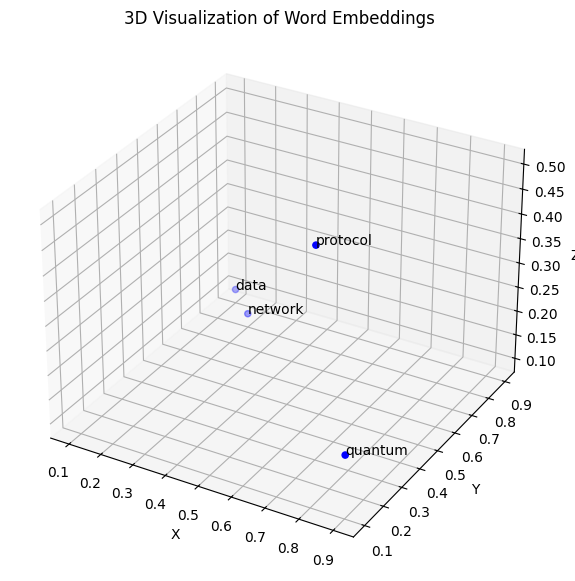

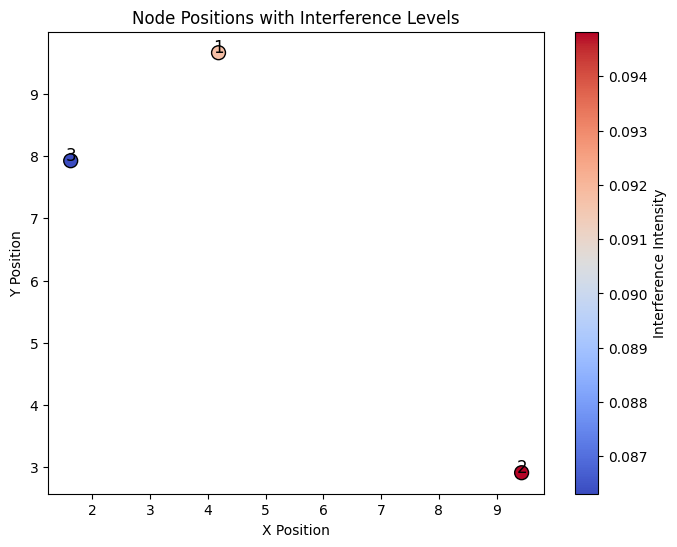

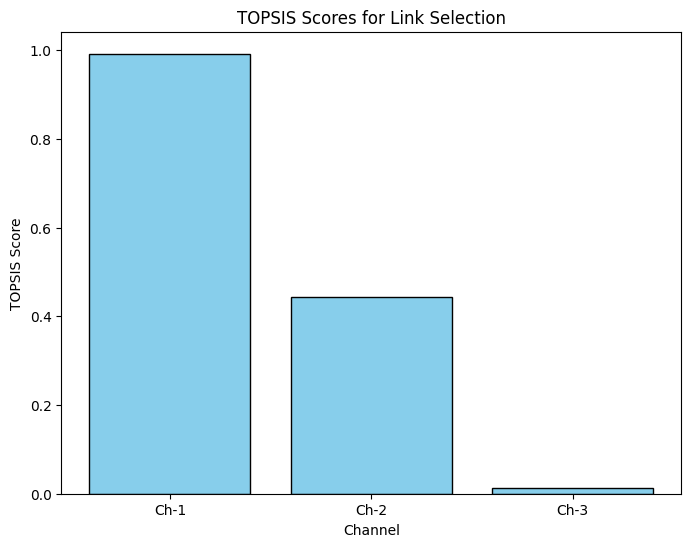


Fidelity with original state: 0.9531


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.quantum_info import Statevector, DensityMatrix
from sklearn.metrics.pairwise import cosine_similarity

# ==========================
# 1. Quantum Semantic Encoder
# ==========================
class QuantumSemanticEncoder:
    def __init__(self, word_embeddings):
        self.words = list(word_embeddings.keys())
        self.embeddings = np.array(list(word_embeddings.values()))
        # Number of qubits should match the size of each embedding vector
        self.num_qubits = len(self.embeddings[0])  # Set qubits to match the embedding size
        self.normalized_embeddings = self.embeddings / np.linalg.norm(self.embeddings, axis=1, keepdims=True)

    def encode_word(self, word):
        if word not in self.words:
            raise ValueError(f"Word '{word}' not found in vocabulary.")
        idx = self.words.index(word)
        embedding = self.normalized_embeddings[idx]
        state = np.zeros(2 ** self.num_qubits, dtype=complex)
        state[:len(embedding)] = embedding
        return Statevector(state)

    def plot_embeddings(self):
        """Visualize word embeddings in 3D."""
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.embeddings[:, 0], self.embeddings[:, 1], self.embeddings[:, 2], color='b', label='Embeddings')
        for i, word in enumerate(self.words):
            ax.text(self.embeddings[i, 0], self.embeddings[i, 1], self.embeddings[i, 2], word)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title("3D Visualization of Word Embeddings")
        plt.show()

    def draw_circuit(self, word):
        """Draw the quantum circuit for encoding the word."""
        if word not in self.words:
            raise ValueError(f"Word '{word}' not found in vocabulary.")
        idx = self.words.index(word)
        embedding = self.normalized_embeddings[idx]

        # Ensure the number of qubits matches the embedding size
        qc = QuantumCircuit(self.num_qubits)
        for i in range(len(embedding)):
            # Apply Ry rotation based on embedding values
            angle = 2 * np.arccos(embedding[i])  # Ensure angle stays within valid range
            qc.ry(angle, i)  # Apply the rotation to each qubit based on the embedding value
        qc.measure_all()
        return qc

# ==========================
# 2. Quantum Stochastic Geometry (QSG)
# ==========================
def generate_node_positions(num_nodes, area_size):
    return np.random.rand(num_nodes, 2) * area_size

def compute_interference(receiver_pos, node_positions, decay_factor=2.0):
    distances = np.linalg.norm(node_positions - receiver_pos, axis=1)
    distances[distances == 0] = 1e-9  # prevent division by zero
    return np.sum(1 / (distances ** decay_factor))

def plot_interference(nodes, interference_values):
    """Visualize node positions and interference."""
    plt.figure(figsize=(8, 6))
    plt.scatter(nodes[:, 0], nodes[:, 1], c=interference_values, cmap='coolwarm', s=100, edgecolors='k')
    for i, (x, y) in enumerate(nodes):
        plt.text(x, y, f'{i+1}', fontsize=12, ha='center')
    plt.colorbar(label='Interference Intensity')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title("Node Positions with Interference Levels")
    plt.show()

# ==========================
# 3. Quantum Channel with Interference
# ==========================
class QuantumChannel:
    def __init__(self, noise_level, position):
        self.noise_level = noise_level
        self.position = position
        self.interference = 0  # will be updated based on QSG

    def transmit(self, statevector):
        rho = np.outer(statevector.data, statevector.data.conj())
        dim = 2 ** statevector.num_qubits
        noisy_rho = (1 - self.noise_level) * rho + (self.noise_level / dim) * np.eye(dim)
        return DensityMatrix(noisy_rho)

# ==========================
# 4. TOPSIS for Link Selection
# ==========================
class TopsisSelector:
    def __init__(self, channels):
        self.channels = channels

    def normalize_matrix(self, matrix):
        norm = np.linalg.norm(matrix, axis=0)
        return matrix / norm

    def topsis_score(self, decision_matrix, weights):
        norm_matrix = self.normalize_matrix(decision_matrix)
        weighted_matrix = norm_matrix * weights
        ideal_best = np.max(weighted_matrix, axis=0)
        ideal_worst = np.min(weighted_matrix, axis=0)
        dist_best = np.linalg.norm(weighted_matrix - ideal_best, axis=1)
        dist_worst = np.linalg.norm(weighted_matrix - ideal_worst, axis=1)
        return dist_worst / (dist_best + dist_worst)

    def select_best_channel(self, semantic_importance):
        # Build decision matrix: [1-noise, 1-interference, semantic importance]
        matrix = []
        for ch in self.channels:
            matrix.append([
                1 - ch.noise_level,
                1 / (1 + ch.interference),  # lower interference → higher score
                semantic_importance
            ])
        matrix = np.array(matrix)
        weights = np.array([0.4, 0.4, 0.2])  # can adjust or compute via FAHP
        scores = self.topsis_score(matrix, weights)
        best_index = np.argmax(scores)
        return self.channels[best_index], scores

    def plot_topsis_scores(self, scores):
        """Plot the TOPSIS scores as a bar chart."""
        plt.figure(figsize=(8, 6))
        plt.bar(range(len(scores)), scores, color='skyblue', edgecolor='black')
        plt.xlabel('Channel')
        plt.ylabel('TOPSIS Score')
        plt.title('TOPSIS Scores for Link Selection')
        plt.xticks(range(len(scores)), [f'Ch-{i+1}' for i in range(len(scores))])
        plt.show()

# ==========================
# 5. Fidelity Calculation
# ==========================
def calculate_fidelity(statevector, density_matrix):
    psi = statevector.data
    rho = density_matrix.data
    return np.vdot(psi, rho @ psi).real

# ==========================
# 6. Example Simulation with Visualizations
# ==========================
if __name__ == "__main__":
    # === Word Embeddings ===
    embeddings = {
        "quantum": [0.9, 0.1, 0.2, 0.3],
        "network": [0.2, 0.8, 0.1, 0.1],
        "protocol": [0.7, 0.3, 0.5, 0.2],
        "data": [0.1, 0.9, 0.1, 0.3]
    }
    encoder = QuantumSemanticEncoder(embeddings)

    # === Generate Channels with QSG ===
    area_size = 10
    num_channels = 3
    receiver_position = np.array([5.0, 5.0])
    channel_positions = generate_node_positions(num_channels, area_size)
    noise_levels = [0.05, 0.3, 0.5]

    channels = []
    for i in range(num_channels):
        ch = QuantumChannel(noise_levels[i], channel_positions[i])
        ch.interference = compute_interference(receiver_position, np.delete(channel_positions, i, axis=0))
        channels.append(ch)

    # === Select Word and Importance ===
    word = "quantum"
    importance = 0.9

    # === Encode and Select Best Channel ===
    encoded = encoder.encode_word(word)
    selector = TopsisSelector(channels)
    best_channel, scores = selector.select_best_channel(importance)

    print("\nTOPSIS Scores:", scores)
    print("Selected channel:")
    print(f"  Noise: {best_channel.noise_level}")
    print(f"  Interference: {best_channel.interference:.4f}")
    print(f"  Position: {best_channel.position}")

    # === Visualizations ===
    encoder.plot_embeddings()
    plot_interference(channel_positions, [ch.interference for ch in channels])
    selector.plot_topsis_scores(scores)

    # === Draw the Quantum Circuit ===
    qc = encoder.draw_circuit(word)
    qc.draw('mpl')  # Draw the quantum circuit

    # === Transmit and Evaluate Fidelity ===
    received = best_channel.transmit(encoded)
    fidelity = calculate_fidelity(encoded, received)
    print(f"\nFidelity with original state: {fidelity:.4f}")
